In [55]:
import scanpy as sc
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import igraph as ig
import pandas as pd

In [2]:
dataset = sc.read('filtered_data.h5ad')
encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset.obs['Manually_curated_celltype'])

In [3]:
list_ct = dataset.obs['Manually_curated_celltype'].unique().tolist()
list_num_ct = encoder_celltype.transform(list_ct)

In [4]:
list_inner_nodes = ['Cross-tissue Immune Cell Atlas', 'B cell', 'Germinal center B cell', 'Myeloid', 'Dendritic cell',
                    'Macrophages', 'Monocytes', 'T & Innate lymphoid cells', 'CD4', 'T Naive', 'CD8', 
                    'Tissue-resident memory T (Trm) cells', 'NK']

In [5]:
all_nodes = list_ct + list_inner_nodes

In [6]:
len(list_inner_nodes)+len(list_ct)

50

In [7]:
import yaml

with open("CellTypist_Updated_3.yaml", "r") as stream:
    try:
        tree = (yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

for key in all_nodes:
    if key not in str(tree):
        print(key)

In [8]:
encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(all_nodes)
def transfrom(x):
    list = [x]
    return encoder_celltype_inner.transform(list)[0]

In [68]:
encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype_inner.transform
    }
}

In [20]:
g = ig.Graph()
g.add_vertices(len(all_nodes))
g.vs['name'] = encoder_celltype_inner.inverse_transform(list(range(len(all_nodes))))
g.add_edges([(transfrom('Cross-tissue Immune Cell Atlas'), transfrom('B cell')),
             (transfrom('Cross-tissue Immune Cell Atlas'), transfrom('Myeloid')),
             (transfrom('Cross-tissue Immune Cell Atlas'), transfrom('T & Innate lymphoid cells'))])
g.add_edges([(transfrom('B cell'), transfrom('ABCs')),
             (transfrom('B cell'), transfrom('Germinal center B cell')),
             (transfrom('B cell'), transfrom('Memory B cells')),
             (transfrom('B cell'), transfrom('Naive B cells')),
             (transfrom('B cell'), transfrom('Plasma cells')),
             (transfrom('B cell'), transfrom('Plasmablasts')),
             (transfrom('B cell'), transfrom('Pre-B')),
             (transfrom('B cell'), transfrom('Pro-B'))])
g.add_edges([(transfrom('Germinal center B cell'), transfrom('GC_B (I)')),
             (transfrom('Germinal center B cell'), transfrom('GC_B (II)'))])
g.add_edges([(transfrom('Myeloid'), transfrom('Cycling')),
             (transfrom('Myeloid'), transfrom('Dendritic cell')),
             (transfrom('Myeloid'), transfrom('Macrophages')),
             (transfrom('Myeloid'), transfrom('Monocytes'))])
g.add_edges([(transfrom('Dendritic cell'), transfrom('DC1')),
             (transfrom('Dendritic cell'), transfrom('DC2')),
             (transfrom('Dendritic cell'), transfrom('migDC'))])
g.add_edges([(transfrom('Macrophages'), transfrom('Alveolar macrophages')),
             (transfrom('Macrophages'), transfrom('Erythrophagocytic macrophages')),
             (transfrom('Macrophages'), transfrom('Intermediate macrophages')),
             (transfrom('Macrophages'), transfrom('Intestinal macrophages'))])
g.add_edges([(transfrom('Monocytes'), transfrom('Classical monocytes')),
             (transfrom('Monocytes'), transfrom('Nonclassical monocytes'))])
g.add_edges([(transfrom('T & Innate lymphoid cells'), transfrom('CD4')),
             (transfrom('T & Innate lymphoid cells'), transfrom('CD8')),
             (transfrom('T & Innate lymphoid cells'), transfrom('Cycling T&NK')),
             (transfrom('T & Innate lymphoid cells'), transfrom('ILC3')),
             (transfrom('T & Innate lymphoid cells'), transfrom('NK')),
             (transfrom('T & Innate lymphoid cells'), transfrom('T_CD4/CD8'))])
g.add_edges([(transfrom('CD4'), transfrom('T Naive')),
             (transfrom('CD4'), transfrom('Teffector/EM_CD4')),
             (transfrom('CD4'), transfrom('Tfh')),
             (transfrom('CD4'), transfrom('Tregs')),
             (transfrom('CD4'), transfrom('Trm_Th1/Th17'))])
g.add_edges([(transfrom('CD8'), transfrom('MAIT')),
             (transfrom('CD8'), transfrom('Tem/emra_CD8')),
             (transfrom('CD8'), transfrom('Tgd_CRTAM+')),
             (transfrom('CD8'), transfrom('Tissue-resident memory T (Trm) cells')),
             (transfrom('CD8'), transfrom('Tnaive/CM_CD8')),
             (transfrom('CD8'), transfrom('Trm_Tgd'))])
g.add_edges([(transfrom('NK'), transfrom('NK_CD16+')),
             (transfrom('NK'), transfrom('NK_CD56bright_CD16-'))])
g.add_edges([(transfrom('T Naive'), transfrom('Tnaive/CM_CD4')),
             (transfrom('T Naive'), transfrom('Tnaive/CM_CD4_activated'))])
g.add_edges([(transfrom('Tissue-resident memory T (Trm) cells'), transfrom('Trm/em_CD8')),
             (transfrom('Tissue-resident memory T (Trm) cells'), transfrom('Trm_gut_CD8')),])

# g.write('tree', format='gml')

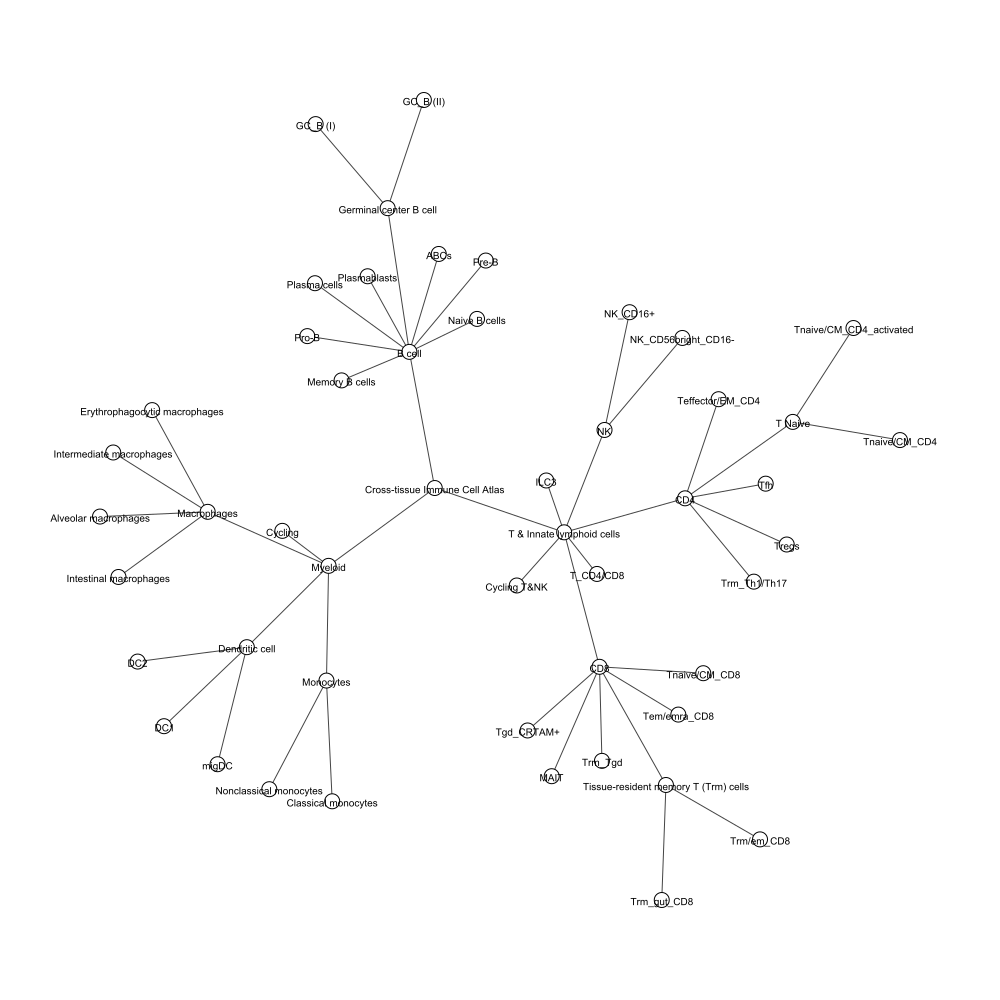

In [38]:
layout = g.layout("kamada_kawai")
ig.plot(g, layout=layout, vertex_label=g.vs["name"], vertex_label_size=10, vertex_size=15, bbox=(1000, 1000), margin=100, vertex_color='white')

In [42]:
def get_shortest_dist(node_1, node_2, graph):
    return len(graph.get_shortest_paths(node_1, node_2)[0])-1

In [59]:
all_nodes_num = encoder_celltype_inner.transform(all_nodes)
dist_df = pd.DataFrame(0, index=np.arange(len(all_nodes_num)), columns=np.arange(len(all_nodes_num)))
for i in range(len(all_nodes_num)):
    for j in range(len(all_nodes_num)):
        dist_df.iloc[i, j]=get_shortest_dist(i, j, g)

In [66]:
import time

import scanpy as sc
from anndata.experimental.pytorch import AnnLoader

import pretty_confusion_matrix as pcm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchnet.meter import ClassErrorMeter, AverageValueMeter
# from torch_prototypes.modules import prototypical_network
import prototypical_network
from torch_prototypes.metrics import distortion, cost
from torch_prototypes.metrics.distortion import DistortionLoss

import matplotlib.pyplot as plt
import seaborn as sns

import helper_fns
import preprocess as pp
from anndata import AnnData
import vanilla_vae

In [67]:
# --------------Parameters-------------------
embedding_dim = 2
hidden_dim = 512
k_fold = 5
cross_validation = False
num_epoch=30
batch_size=512
feature_selection = True
num_genes = 36601
# --------------Plotting---------------------
plot_loss = True
plot_embedding_space = True
plot_confusion_matrix = True

D = dist_df
D = torch.tensor(D.values, dtype=float)

train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset, cross_validation=cross_validation, k_fold=k_fold)
sc.pp.normalize_total(dataset, 1e4)
sc.pp.log1p(dataset)
pca = TruncatedSVD(n_components=100)
pca.fit(dataset[train_indices].X)
dataset_pca = AnnData(pca.transform(dataset.X))
dataset_pca.obs = dataset.obs
dataset = dataset_pca

In [87]:
class PL(nn.Module):
    def __init__(self, centers):
        super(PL, self).__init__()
        self.centers = centers

    def forward(self, mapping, labels):
        targets = torch.index_select(self.centers, 0, labels)
        dist = torch.norm(mapping - targets, dim=1)
        dist = torch.sum(dist)
        return dist/mapping.shape[0]

def train_nn(l_metric=2, l_pl = 8, epochs = num_epoch, D_metric=None, D_cost=D, cuda=1):
    D_metric = D_metric.cuda()
    model_vae = vanilla_vae.VanillaVAE(100, 2, [128, 64, 32]).cuda()
    model = prototypical_network.LearntPrototypes(model_vae, n_prototypes= D_metric.shape[0],
                                prototypes=None, embedding_dim=embedding_dim, device='cuda').cuda()
    
    delta = DistortionLoss(D_metric)
    criterion = nn.CrossEntropyLoss()
    ac = cost.AverageCost(D_cost)

    opt = torch.optim.Adam(model.parameters())
    if plot_loss:
        losses = {'loss_xe':[],'loss_disto':[],'loss_pl':[],'loss_vae':[], 'loss_reconst':[], 'loss_kl':[]}
    if plot_embedding_space:
        embedding_space = {'training_embeddings':[],'training_labels':[],'testing_embeddings':[],'testing_pred_labels':[],'testing_true_labels':[]}
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))
        ER_meter = ClassErrorMeter(accuracy=False)
        AC_meter = AverageValueMeter()

        model.train()
        t0 = time.time()
        if plot_loss:
            batch_losses = {'loss_xe':[],'loss_disto':[],'loss_pl':[],'loss_vae':[], 'loss_reconst':[], 'loss_kl':[]}
        for batch in dataloader_training:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(x)
            opt.zero_grad()
            vae_loss = model_vae.loss_function(x_hat, x, mean, log_var, decoder_mu,decoder_log_var, M_N=1)
            pl_loss = PL(centers = model.prototypes.data)
            pl_loss_ = pl_loss(embeddings, y)
            if epoch == epochs and plot_embedding_space:
                embedding_space['training_embeddings'].extend(embeddings)
                embedding_space['training_labels'].extend(y)
            loss = criterion(out, y) +  l_metric * delta(model.prototypes) + l_pl*pl_loss_ + vae_loss['loss']
            
            if plot_loss:
                batch_losses['loss_xe'].append(criterion(out, y).detach().cpu())
                batch_losses['loss_disto'].append((l_metric * delta(model.prototypes)).detach().cpu())
                batch_losses['loss_pl'].append(l_pl*pl_loss_.detach().cpu())
                batch_losses['loss_vae'].append(vae_loss['loss'].detach().cpu())
                batch_losses['loss_reconst'].append(vae_loss['Reconstruction_Loss'].detach().cpu())
                batch_losses['loss_kl'].append(vae_loss['KLD'].detach().cpu())

            loss.backward()
            opt.step()
            pred = out.detach()
            ER_meter.add(pred.cpu(),y.cpu())
            AC_meter.add(ac(pred.cpu(),y.cpu()))
        
        if plot_loss:
            losses['loss_xe'].append(np.array(batch_losses['loss_xe']).mean())
            losses['loss_disto'].append(np.array(batch_losses['loss_disto']).mean())
            losses['loss_pl'].append(np.array(batch_losses['loss_pl']).mean())
            losses['loss_vae'].append(np.array(batch_losses['loss_vae']).mean())
            losses['loss_reconst'].append(np.array(batch_losses['loss_reconst']).mean())
            losses['loss_kl'].append(np.array(batch_losses['loss_kl']).mean())

        t1 = time.time()
        
        print('Train ER {:.2f}, AC {:.3f}, time {:.1f}s'.format(ER_meter.value()[0], AC_meter.value()[0], t1-t0))

        model.eval()
        ER_meter = ClassErrorMeter(accuracy=False)
        AC_meter = AverageValueMeter()
        t0 = time.time()
        for batch in dataloader_testing:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            with torch.no_grad():
                out, embedding_y, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(x)
            pred = out.detach()
            if epoch == epochs and plot_embedding_space:
                embedding_space['testing_embeddings'].extend(embedding_y)
                embedding_space['testing_pred_labels'].extend(pred.cpu().numpy())
                embedding_space['testing_true_labels'].extend(y)
            ER_meter.add(pred.cpu(),y)
            AC_meter.add(ac(pred.cpu(),y))
        t1 = time.time()
        print('Test ER {:.2f}, AC {:.3f}, time {:.1f}s'.format(ER_meter.value()[0], AC_meter.value()[0], t1-t0))
        results = {}
        results['model'] = model
        if plot_loss:
            results['losses'] = losses
        if plot_embedding_space:
            results['embedding_space'] = embedding_space
    return results

In [86]:
num_epoch=200

In [88]:
kfold = KFold(n_splits=k_fold, shuffle=True)
# Start print
print('--------------------------------')
model_list = []

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
      # Print
      print(f'FOLD {fold}')
      print('--------------------------------')

      # Sample elements randomly from a given list of ids, no replacement.
      train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
      test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
      
      dataloader_training = AnnLoader(dataset, batch_size=batch_size, convert=encoders, sampler=train_subsampler)
      dataloader_testing = AnnLoader(dataset, batch_size=batch_size, convert=encoders, sampler=test_subsampler)

      results = train_nn(D_metric=D, l_metric=1)
      model_list.append(results)
      
      if not cross_validation:
            break

--------------------------------
FOLD 0
--------------------------------
Epoch 1
Train ER 94.83, AC 4.705, time 1.3s
Test ER 93.30, AC 4.081, time 0.1s
Epoch 2
Train ER 91.97, AC 4.012, time 1.1s
Test ER 92.18, AC 3.955, time 0.1s
Epoch 3
Train ER 91.33, AC 3.824, time 1.2s
Test ER 90.26, AC 3.738, time 0.1s
Epoch 4
Train ER 89.50, AC 3.658, time 1.0s
Test ER 87.60, AC 3.542, time 0.1s
Epoch 5
Train ER 86.68, AC 3.468, time 1.1s
Test ER 85.14, AC 3.351, time 0.1s
Epoch 6
Train ER 85.06, AC 3.298, time 1.1s
Test ER 84.10, AC 3.238, time 0.1s
Epoch 7
Train ER 83.54, AC 3.136, time 1.2s
Test ER 82.26, AC 3.037, time 0.1s
Epoch 8
Train ER 81.81, AC 2.939, time 1.1s
Test ER 80.76, AC 2.892, time 0.1s
Epoch 9
Train ER 79.51, AC 2.778, time 1.1s
Test ER 77.46, AC 2.702, time 0.1s
Epoch 10
Train ER 76.74, AC 2.617, time 1.2s
Test ER 74.08, AC 2.507, time 0.1s
Epoch 11
Train ER 73.79, AC 2.439, time 1.1s
Test ER 71.04, AC 2.358, time 0.1s
Epoch 12
Train ER 70.56, AC 2.296, time 1.1s
Test ER 70.

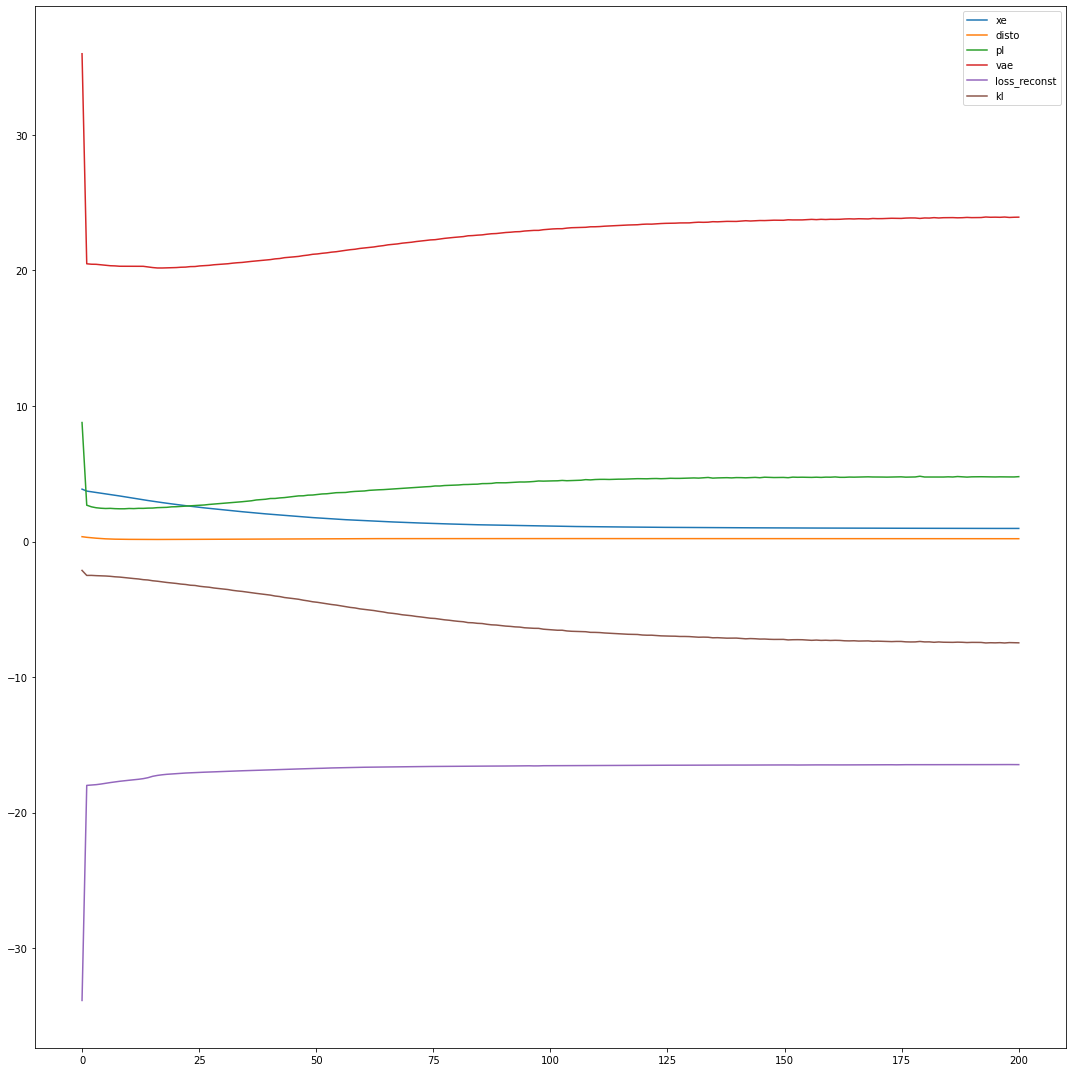

In [89]:
if plot_loss:
    plt.figure(figsize=(15, 15))
    ax = plt.axes()

    x = np.linspace(0, len(results.get('losses')['loss_pl']), len(results.get('losses')['loss_pl']))
    plt.plot(x, np.array(results.get('losses')['loss_xe']), label='xe')
    plt.plot(x, np.array(results.get('losses')['loss_disto']), label='disto')
    plt.plot(x, np.array(results.get('losses')['loss_pl']), label='pl')
    plt.plot(x, np.array(results.get('losses')['loss_vae']), label='vae') 
    plt.plot(x, np.array(results.get('losses')['loss_reconst']), label='loss_reconst') 
    plt.plot(x, np.array(results.get('losses')['loss_kl']), label='kl') 
    plt.legend()

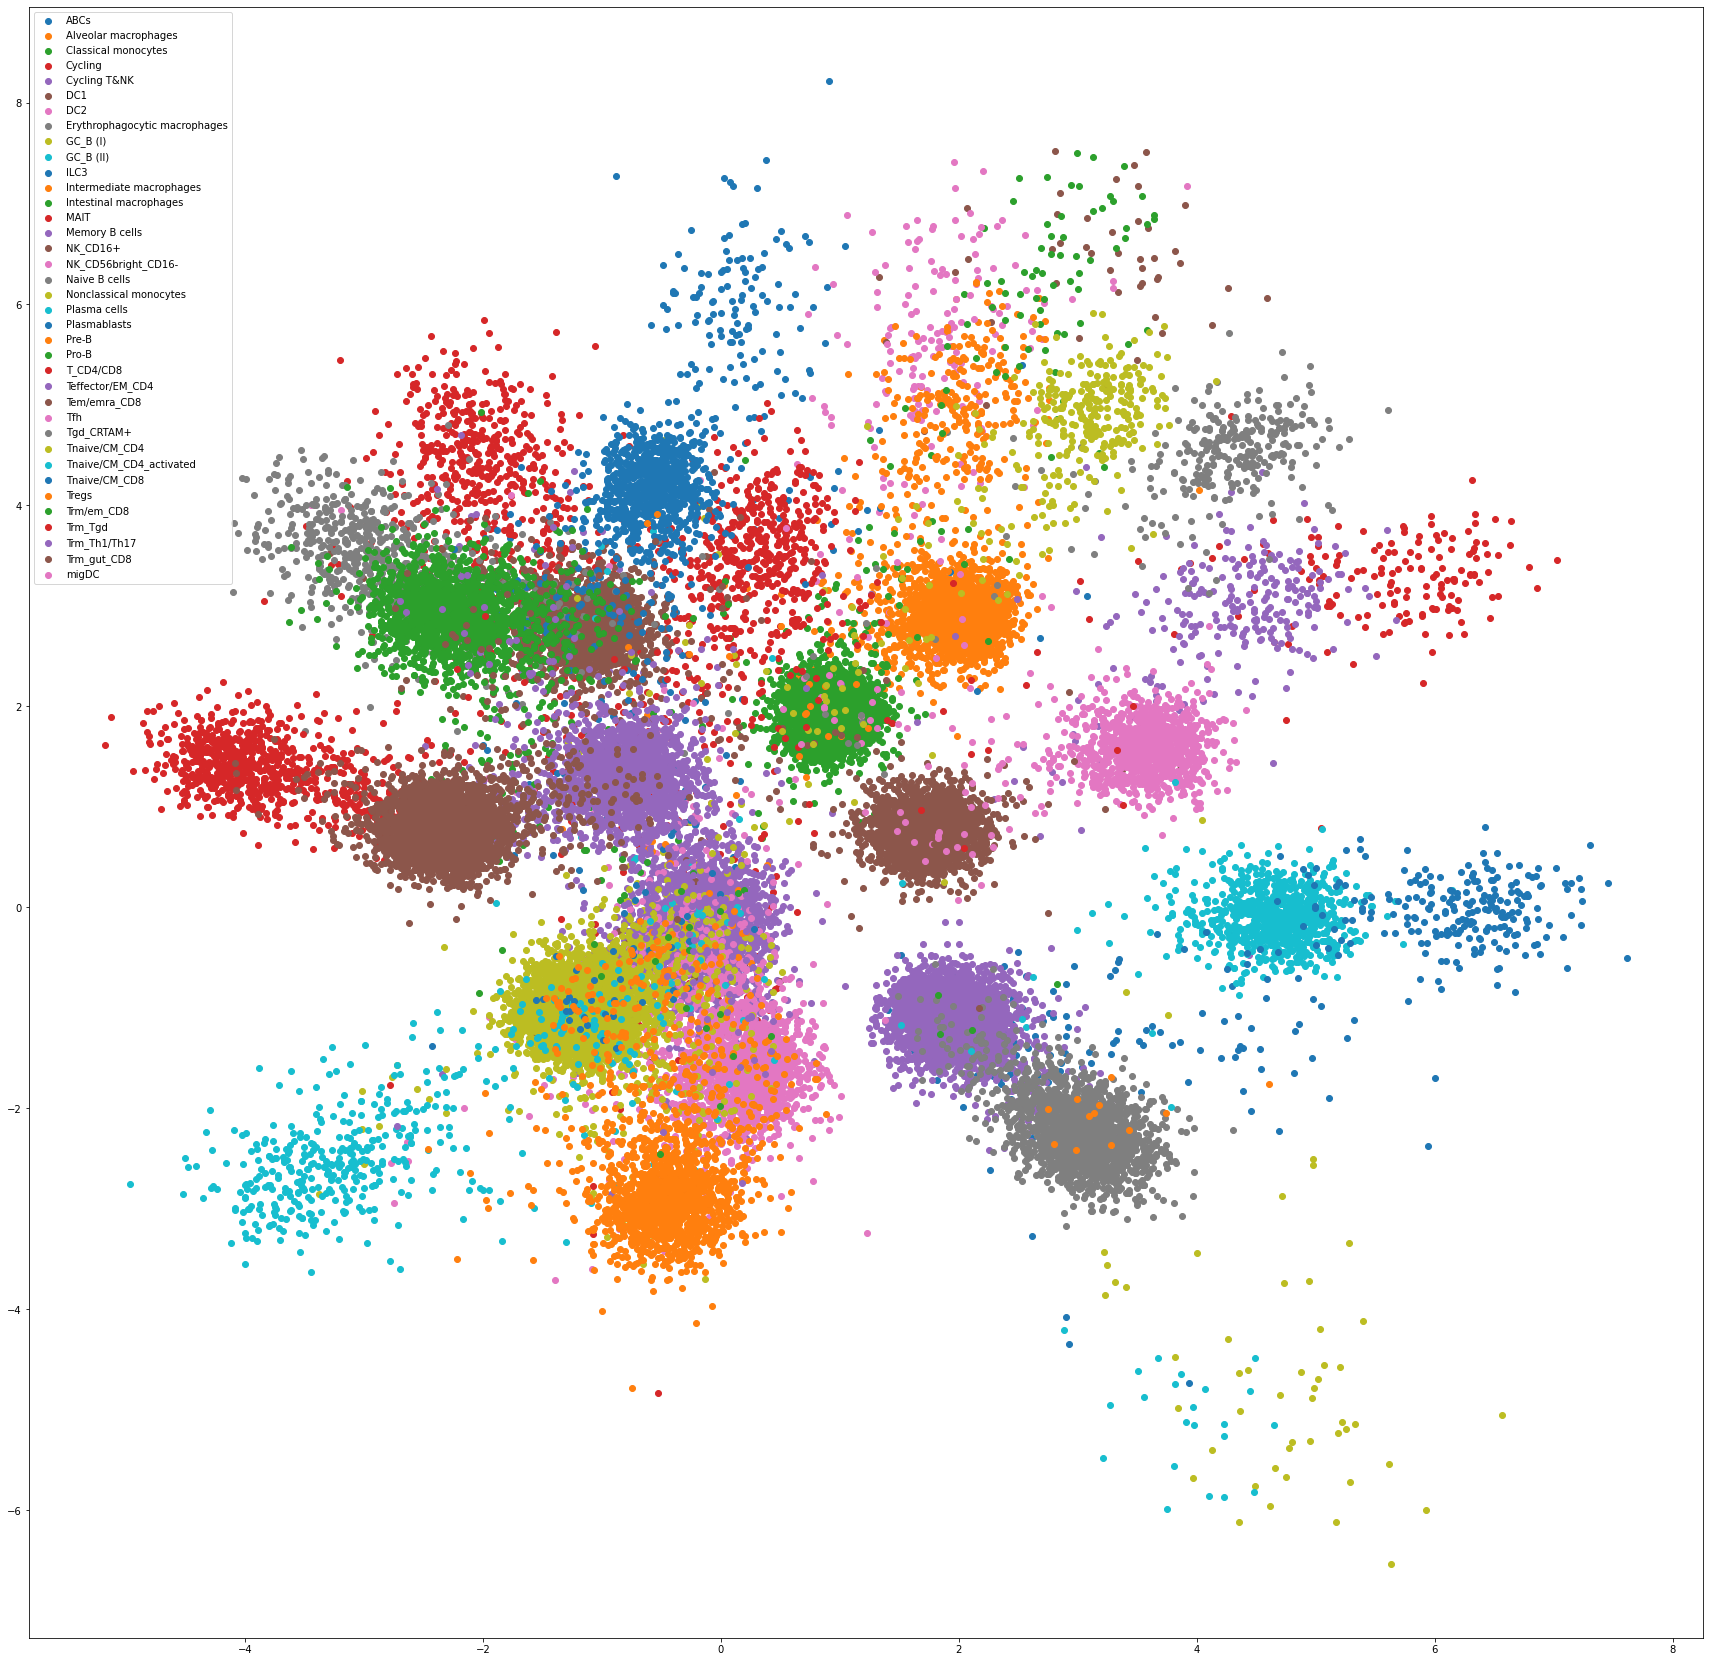

In [78]:
# Training
training_embeddings = results.get('embedding_space')['training_embeddings']
training_embeddings_labels = results.get('embedding_space')['training_labels']
for i in range(len(training_embeddings_labels)):
    if type(training_embeddings[i]) != np.ndarray:
        training_embeddings[i] = training_embeddings[i].detach().cpu().numpy()
    if type(training_embeddings_labels[i]) != np.ndarray:
        training_embeddings_labels[i] = training_embeddings_labels[i].detach().cpu().numpy()
if plot_embedding_space:
    training_embeddings_labels=encoder_celltype_inner.inverse_transform(training_embeddings_labels)
    fig, ax = plt.subplots(figsize=(30, 30))
    for color in np.unique(np.array(training_embeddings_labels)):
        i = np.where(np.array(training_embeddings_labels) == color)
        ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1], label=color)
    ax.legend()
    plt.show()

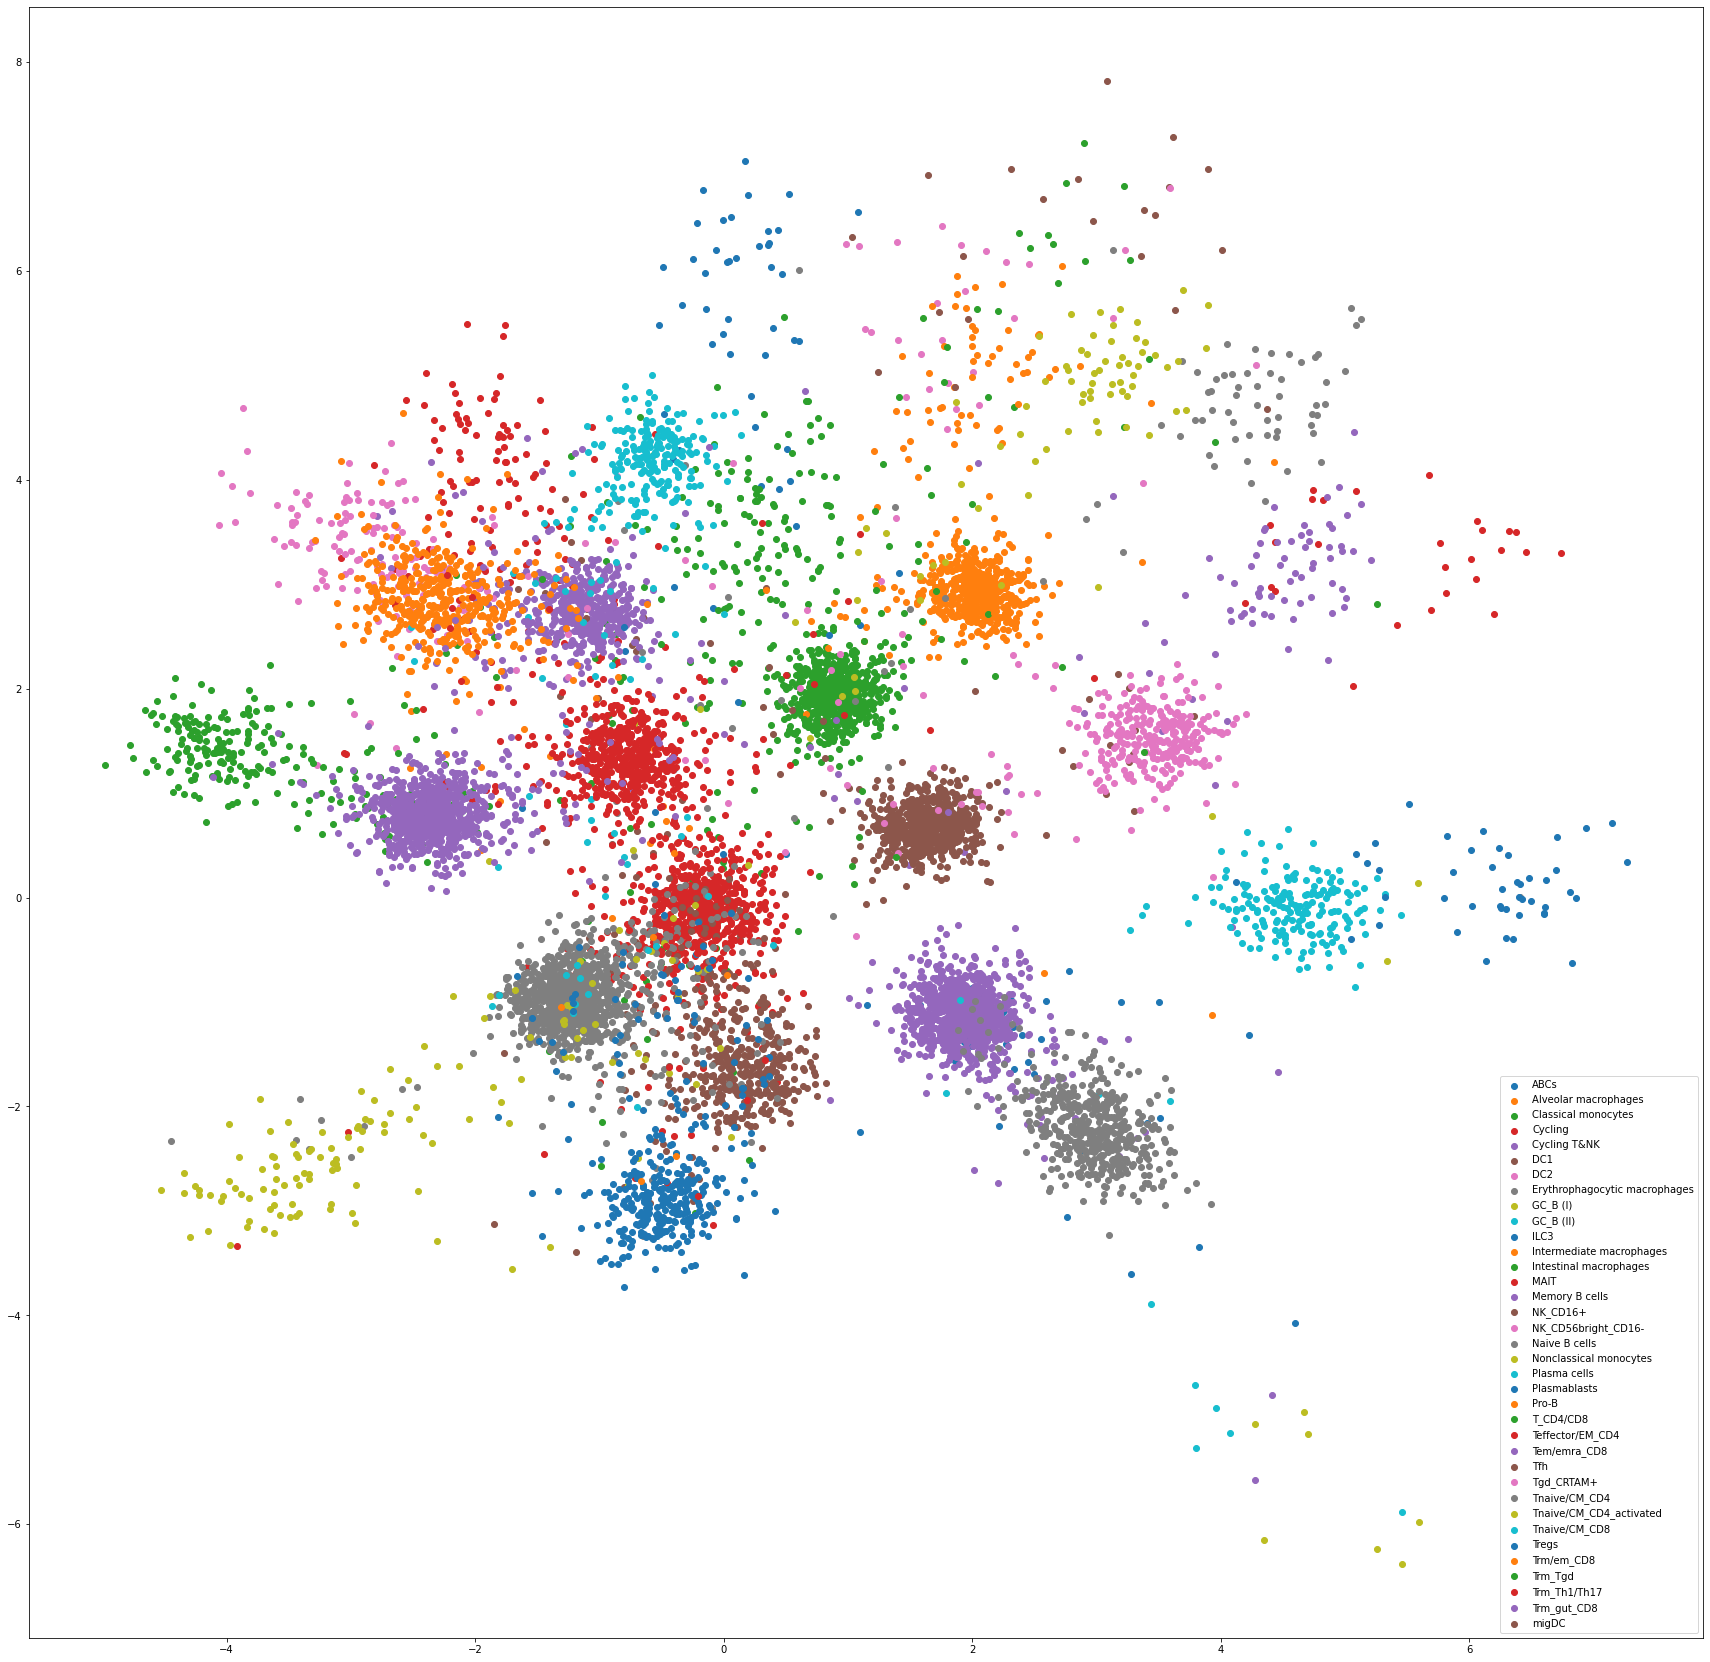

In [79]:
# Testing & True labels
test_embeddings = results.get('embedding_space')['testing_embeddings']
test_true_labels = results.get('embedding_space')['testing_true_labels']
if type(test_embeddings[0]) != np.ndarray:
    for i in range(len(test_embeddings)):
        test_embeddings[i] = test_embeddings[i].cpu().numpy()
        test_true_labels[i] = test_true_labels[i].cpu()
test_true_labels=encoder_celltype_inner.inverse_transform(test_true_labels)
if plot_embedding_space:
    fig, ax = plt.subplots(figsize=(30, 30))
    for color in np.unique(np.array(test_true_labels)):
        i = np.where(test_true_labels == color)
        ax.scatter(np.array(test_embeddings)[i,0], np.array(test_embeddings)[i,1], label=color)
    ax.legend()
    plt.show()

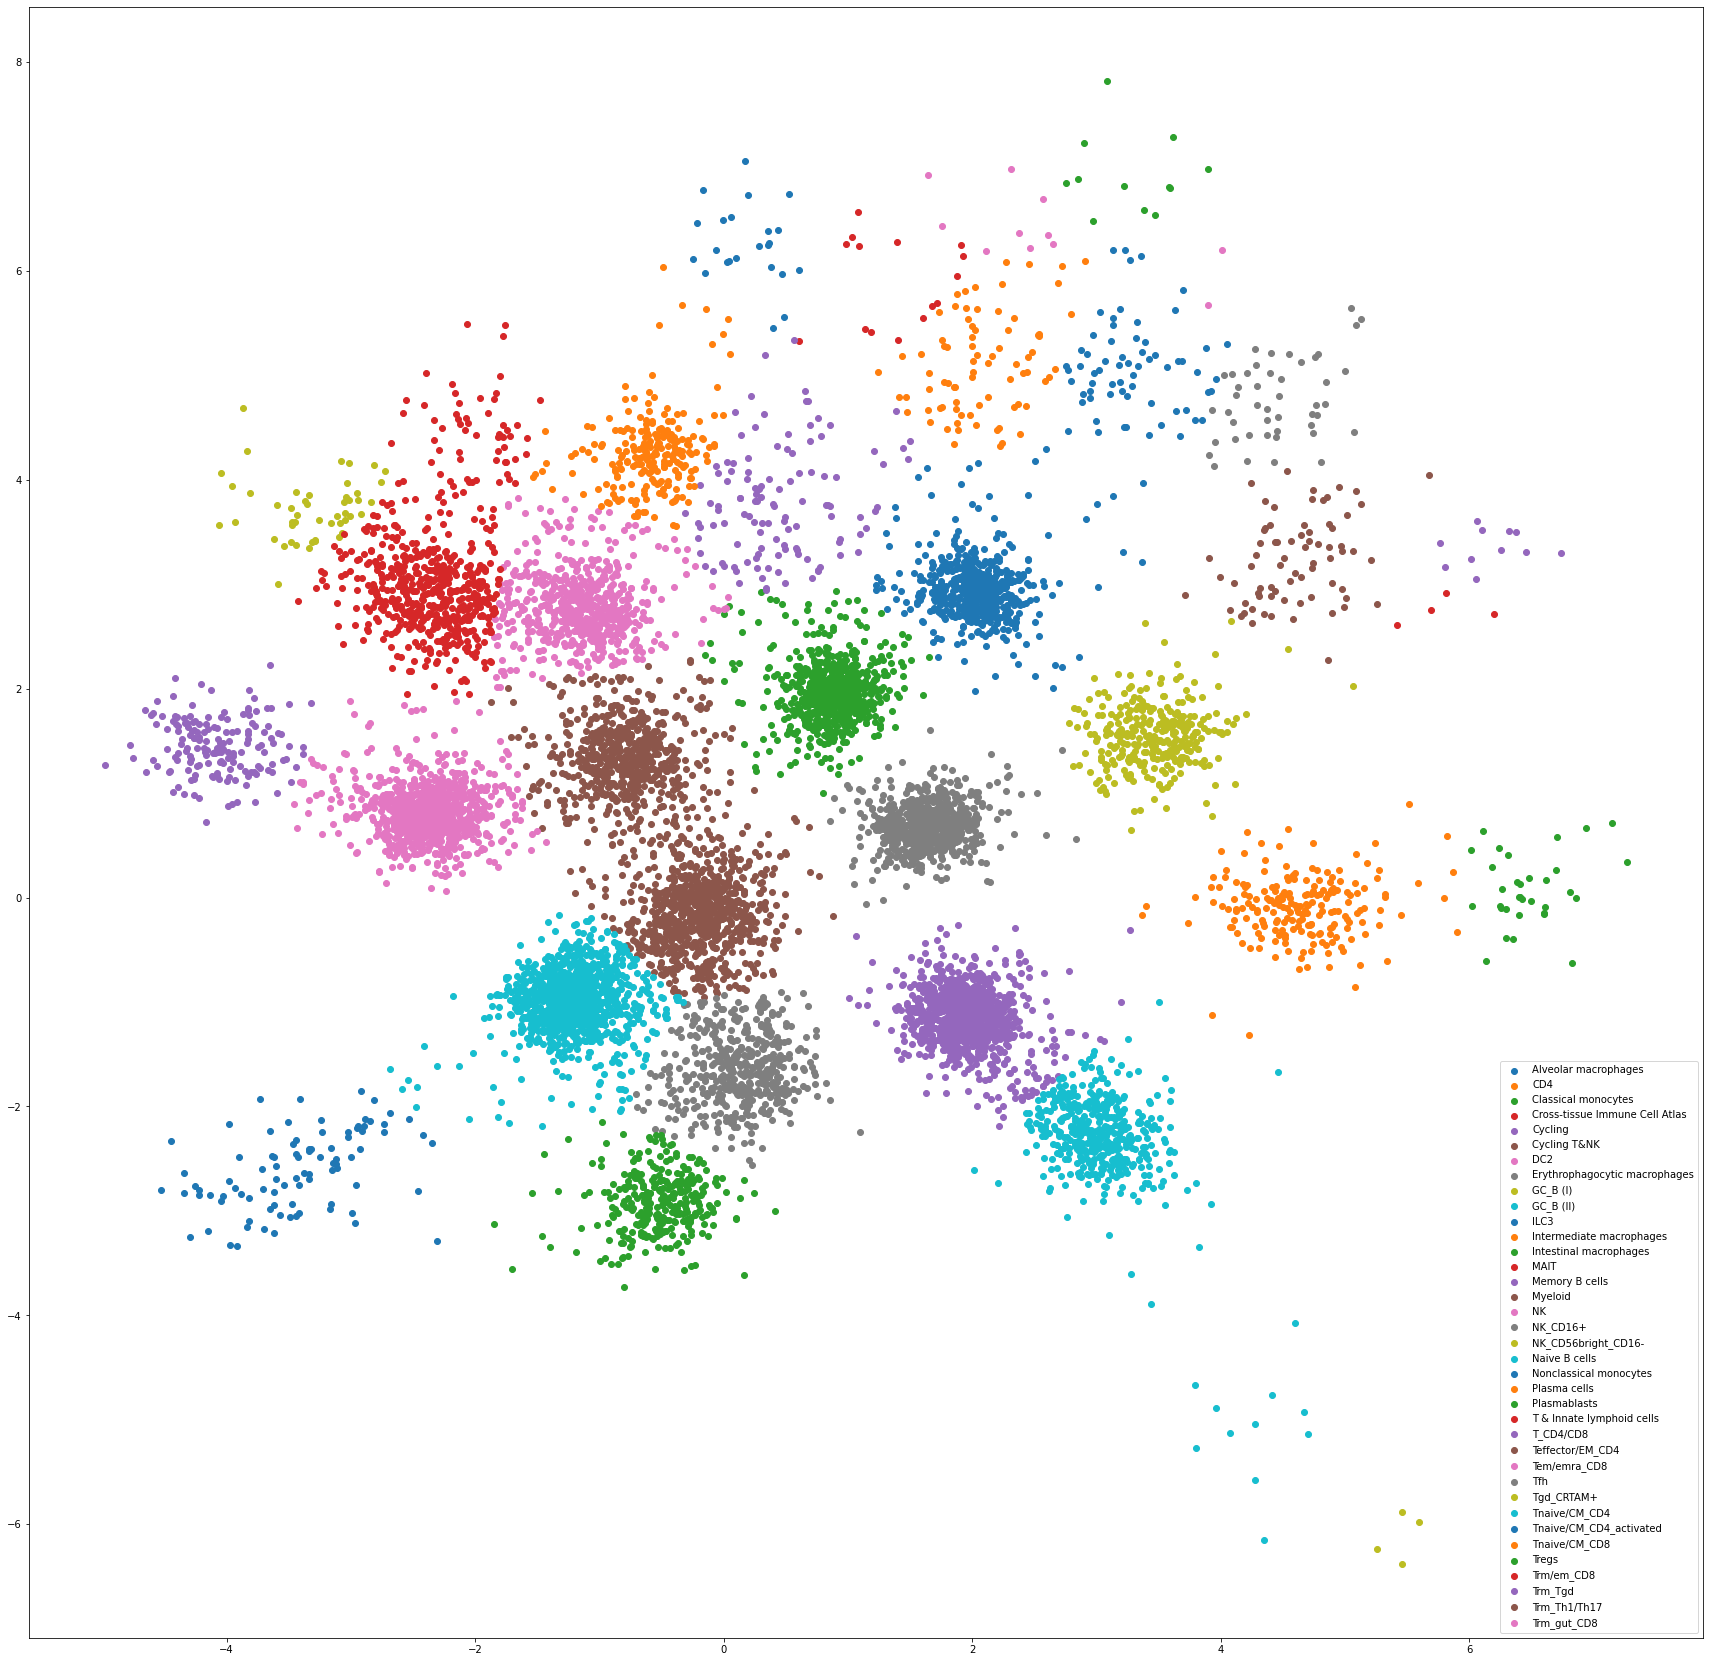

In [80]:
# Testing & Pred labels
test_embeddings = results.get('embedding_space')['testing_embeddings']
test_pred_labels = results.get('embedding_space')['testing_pred_labels'].copy()
for i in range(len(test_pred_labels)):
    test_pred_labels[i] = test_pred_labels[i].argmax()

test_pred_labels=encoder_celltype_inner.inverse_transform(test_pred_labels)
if plot_embedding_space:
    fig, ax = plt.subplots(figsize=(30, 30))
    for color in np.unique(np.array(test_pred_labels)):
        i = np.where(test_pred_labels == color)
        ax.scatter(np.array(test_embeddings)[i,0], np.array(test_embeddings)[i,1], label=color)
    ax.legend()
    plt.show()

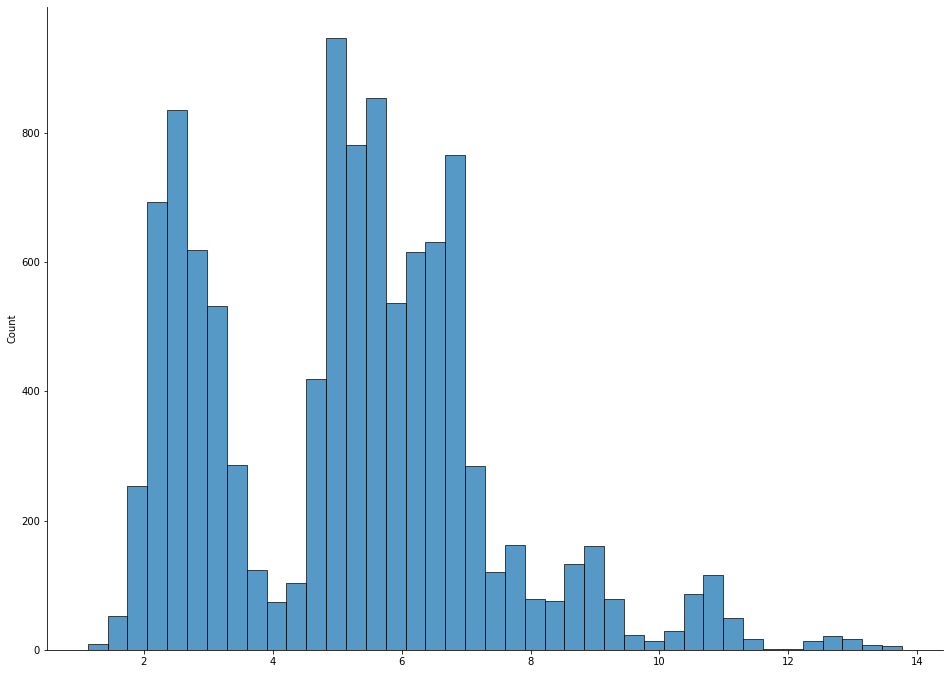

In [81]:
test_pred_dists = results.get('embedding_space')['testing_pred_labels'].copy()
test_pred_labels = encoder_celltype.fit_transform(test_pred_labels)
test_true_labels = encoder_celltype.fit_transform(test_true_labels)
true_pos = []
for i in range(len(test_pred_dists)):
    test_pred_dists[i] = -test_pred_dists[i][test_pred_labels[i]]
    if test_pred_labels[i] == test_true_labels[i]:
        true_pos.append(test_pred_dists[i])

g = sns.displot(test_pred_dists)
g.fig.set_size_inches(15,10)

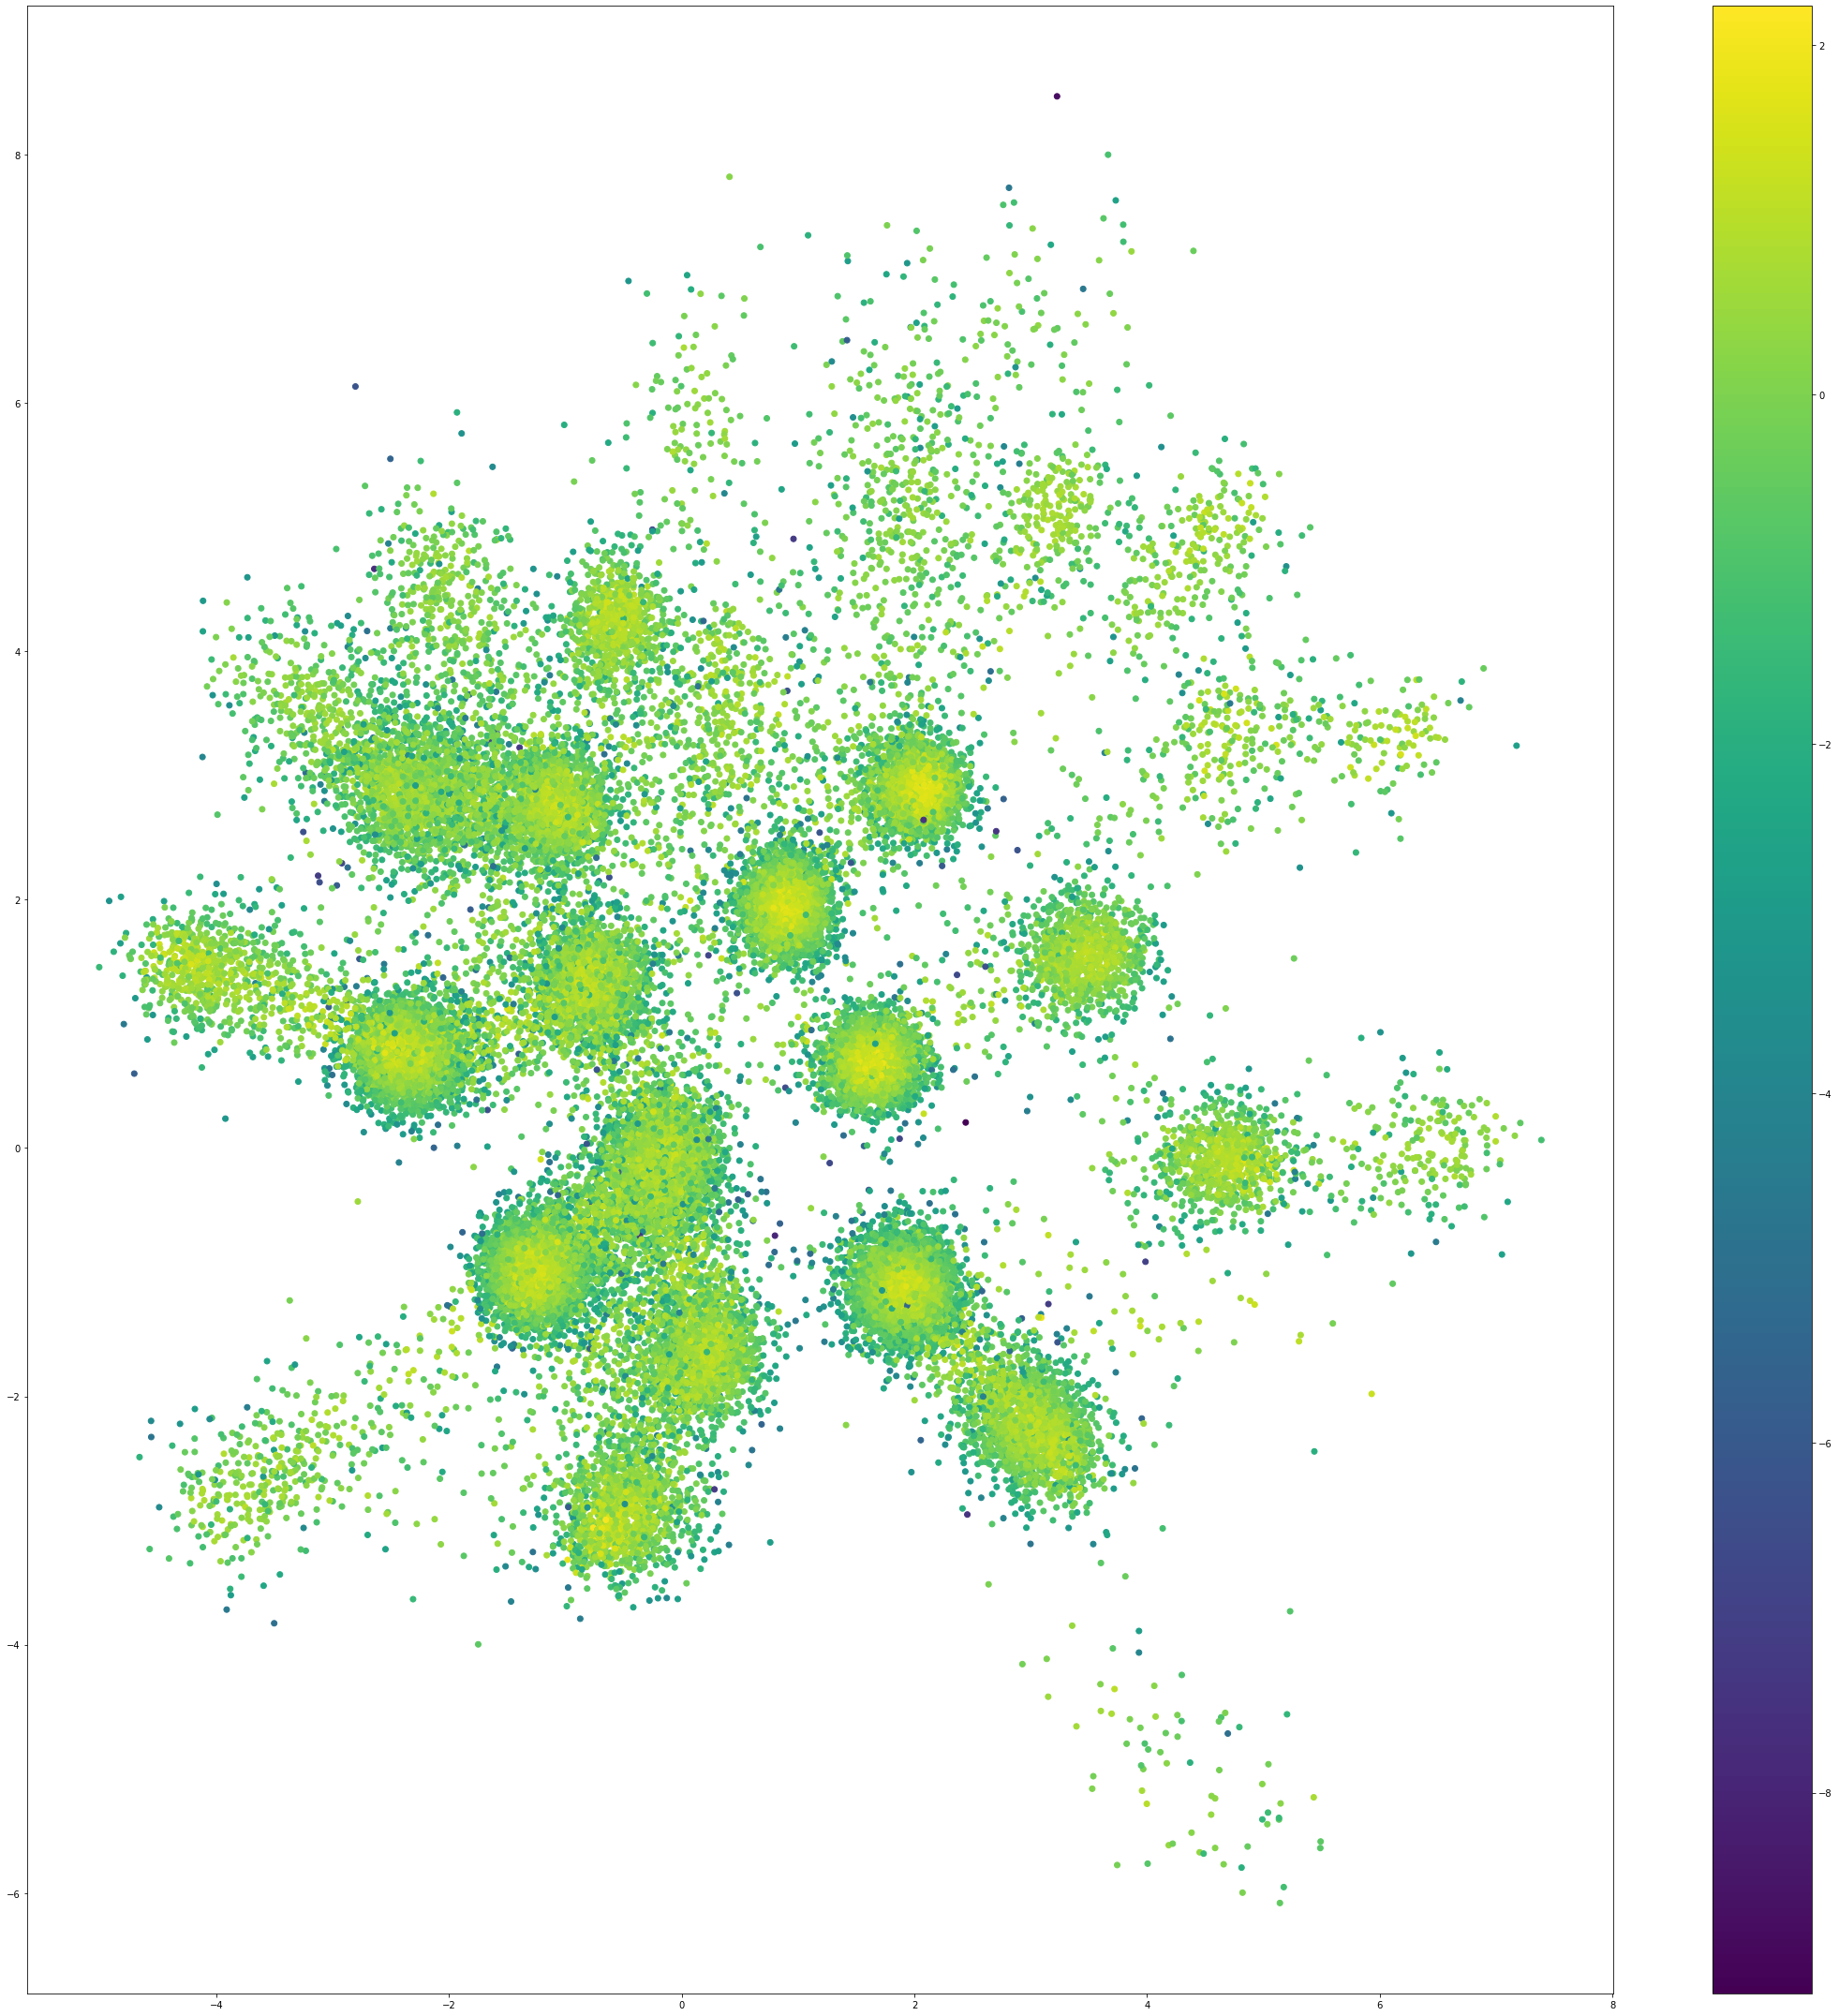

In [83]:
# Training
model = results.get('model')
out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[train_ids].X).cuda())
training_embeddings_likelihoods = helper_fns.log_likelihood_Gaussian(embeddings, mean, log_var)
training_embeddings = []
embedding_likelihoods =[]
for i in range(len(embeddings)):
    if type(embeddings[i]) != np.ndarray:
        training_embeddings.append(embeddings[i].detach().cpu().numpy())
    if type(training_embeddings_likelihoods[i]) != np.ndarray:
        embedding_likelihoods.append(training_embeddings_likelihoods[i].detach().cpu().numpy())
if plot_embedding_space:
    # training_embeddings_labels=encoder_celltype.inverse_transform(training_embeddings_labels)
    fig, ax = plt.subplots(figsize=(30, 30))
    plt.rcParams["figure.autolayout"] = True
    points = ax.scatter(np.array(training_embeddings)[:,0], np.array(training_embeddings)[:,1], c=embedding_likelihoods)
    fig.colorbar(points)
    plt.show()

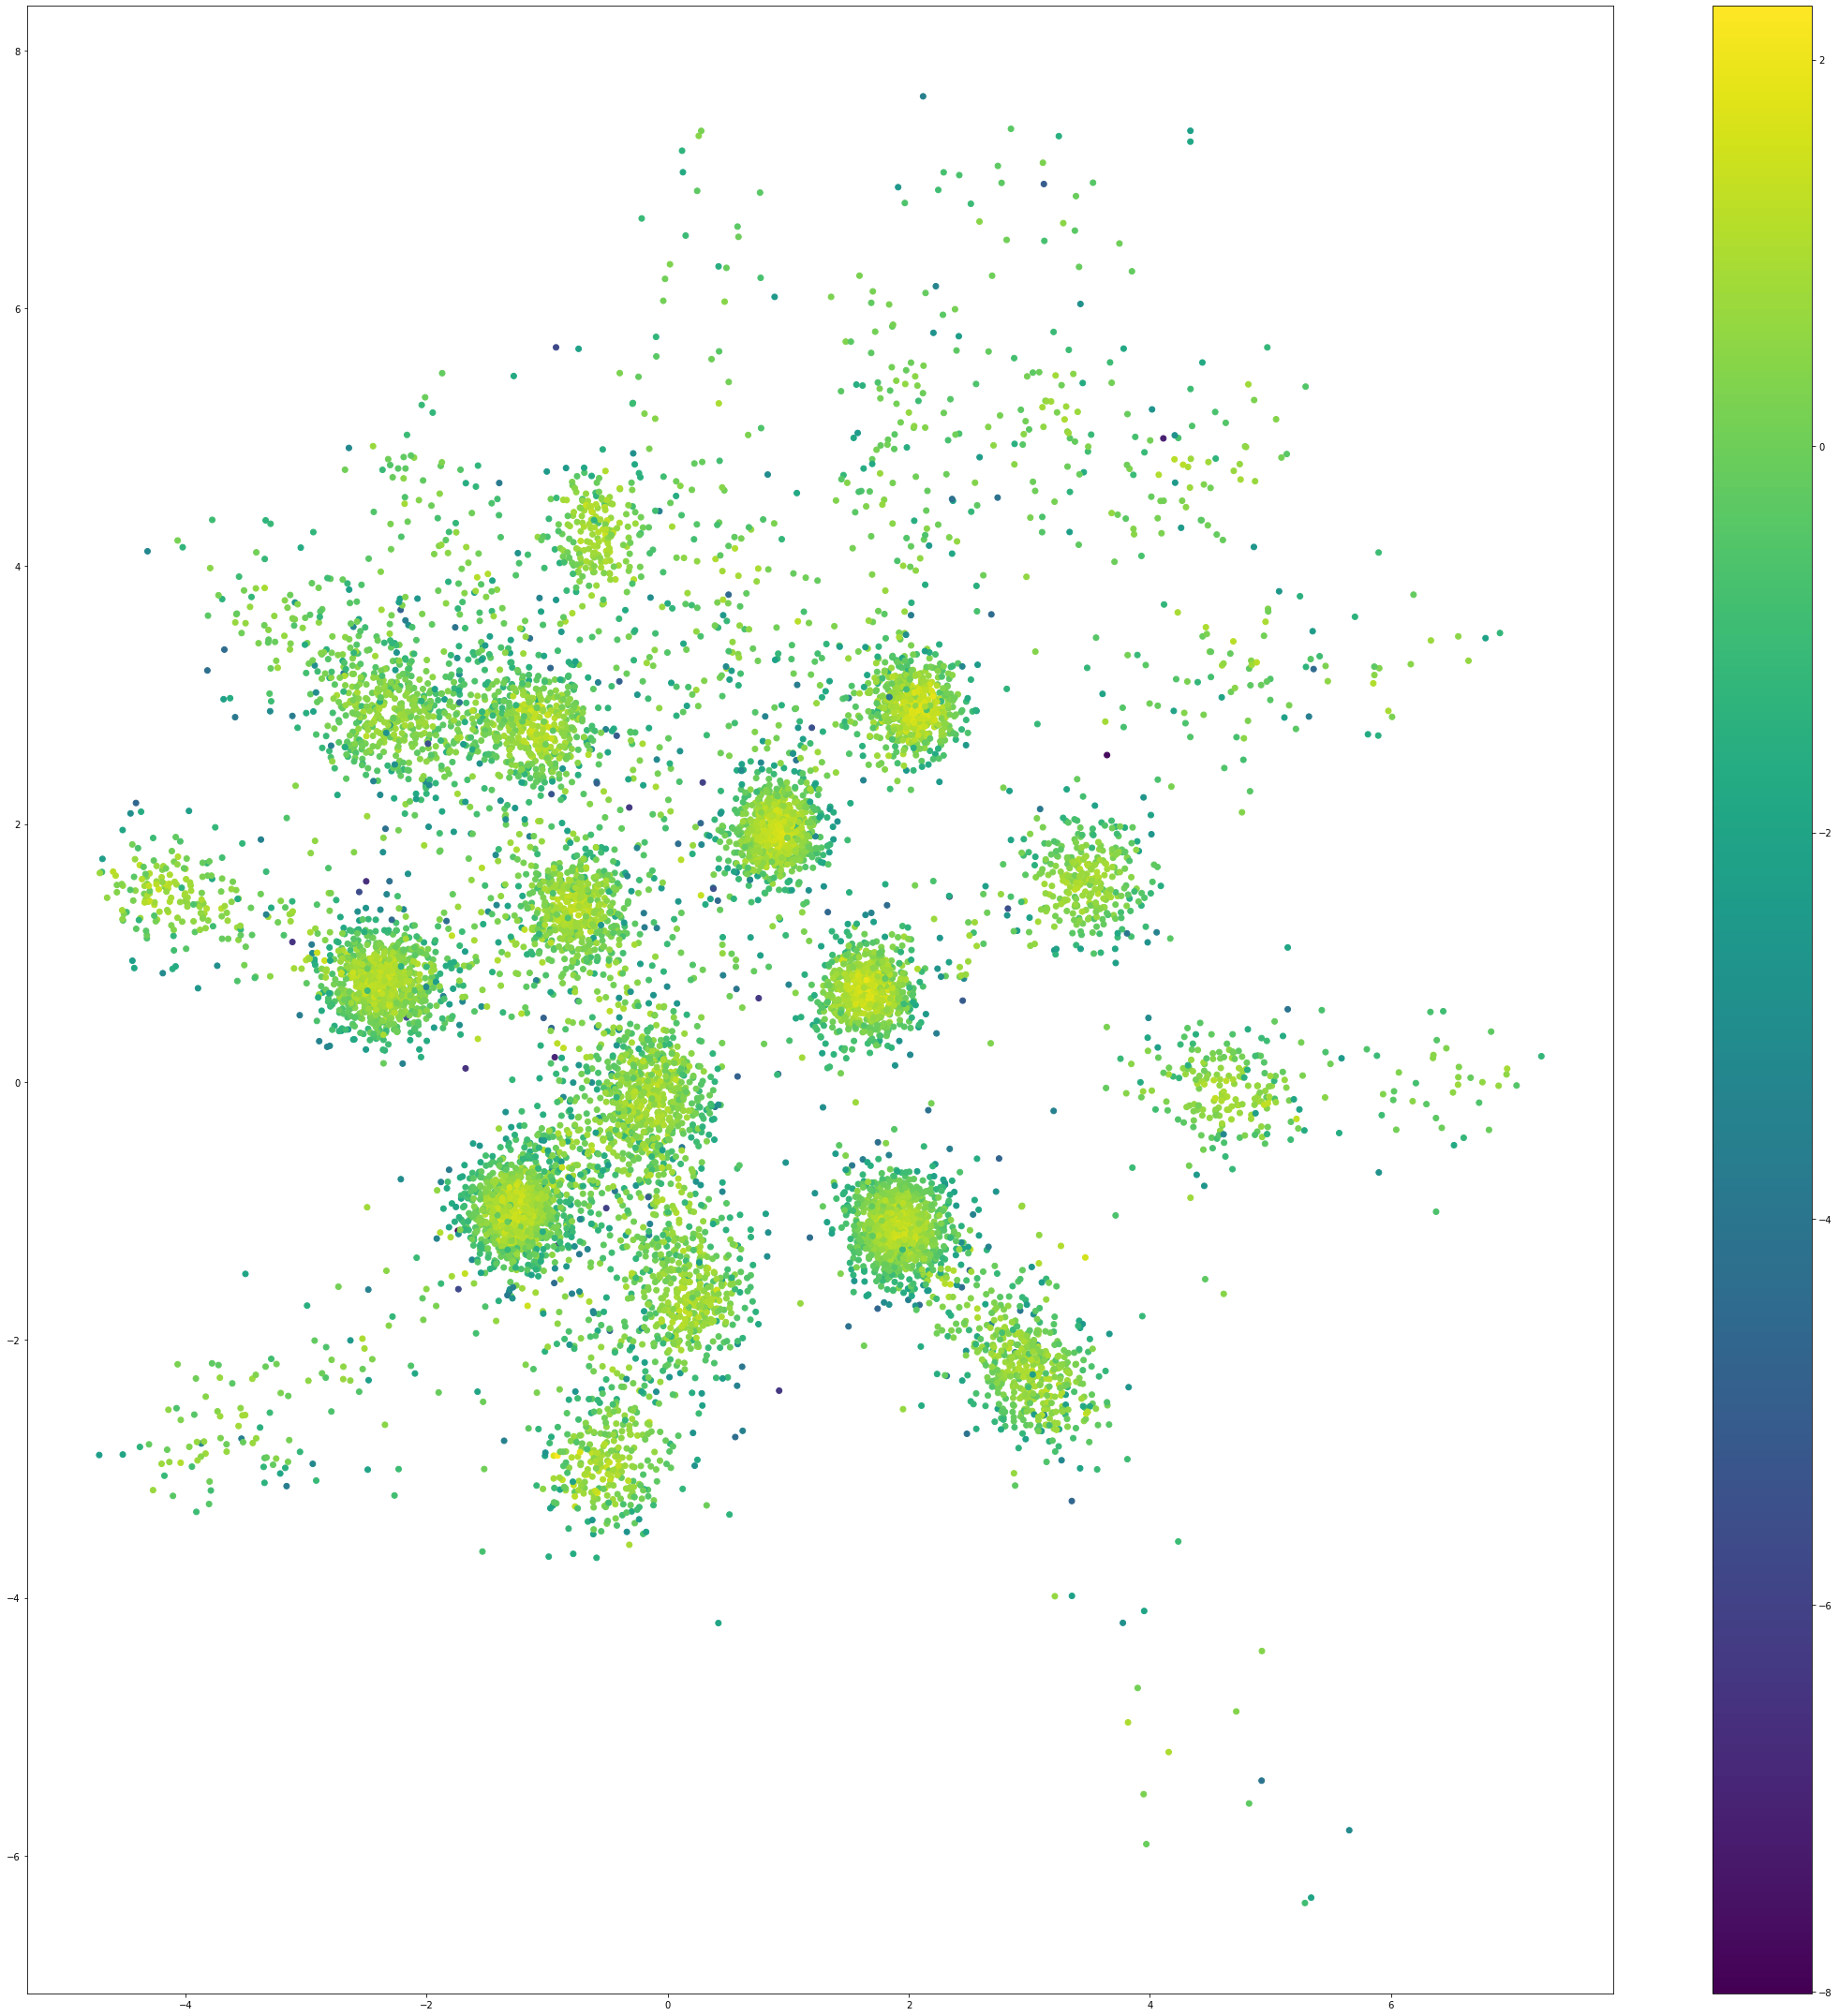

In [85]:
# Testing
model = results.get('model')
out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[test_ids].X).cuda())
training_embeddings_likelihoods = helper_fns.log_likelihood_Gaussian(embeddings, mean, log_var)
training_embeddings = []
embedding_likelihoods =[]
for i in range(len(embeddings)):
    if type(embeddings[i]) != np.ndarray:
        training_embeddings.append(embeddings[i].detach().cpu().numpy())
    if type(training_embeddings_likelihoods[i]) != np.ndarray:
        embedding_likelihoods.append(training_embeddings_likelihoods[i].detach().cpu().numpy())
if plot_embedding_space:
    # training_embeddings_labels=encoder_celltype.inverse_transform(training_embeddings_labels)
    fig, ax = plt.subplots(figsize=(30, 30))
    plt.rcParams["figure.autolayout"] = True
    points = ax.scatter(np.array(training_embeddings)[:,0], np.array(training_embeddings)[:,1], c=embedding_likelihoods)
    fig.colorbar(points)
    plt.show()